In [305]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hcluster
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


# Identify an Unsupervised Learning Problem 

Customer segmentation analysis is the study of the customer. The analysis divides the customers into smaller group to understand who they are and what they do. It usually divided the customers into the following group: geographic segmentation, demographic segmentation, psychographic segmentation, and price segmentation.   The information would be useful for company to understand their customer and create products based on their customer’s need. 

Clustering is a method we learned in class and is typically used to segment customers. I will use k-means clustering for this notebook,and group the customers base on their similarities in demographics, purchase behavior, or other relevant factors. K-means analysis works by starting with an initial set of cluster centroids and iteratively adjusting them to minimize the distance between data points and their assigned centroids. The "k" in k-means represents the number of clusters that the algorithm will be the hyperparameter that I will be choosing

## Data

There is not a whole lot of explanation on what the data is. Most of the columns are self explanatory. From some of the variables, I am guessing the data is from a supermarket. It containes 2240 rows and 29 columns. 

In [254]:

df = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', delimiter='\t')

# Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
## Inspect

In [255]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [257]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [258]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


## Data Cleaning

For data cleaning, we will be focusing on finding null values and duplicated data first. Next we will see if there is any outliers that needs to be removed. Finally from the inspection on the data, education and martial_status are string and will not work for cluster. I need to either one hot encode the category or factorize the feature. I will also consider combine categories to reduce the dimensionality of the data. 29 is not a lot, but it will be better if I can condense it. 

In [259]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [260]:
per = df['Income'].isnull().sum()/len(df['Income'])
print("Missing data", per)

Missing data 0.010714285714285714


There are 24 rows of missing data in income. It's .01 percent of the total data, I don't think it will have a huge impact on the model if we remove those rows.

In [261]:
print("Before", df.shape)
df = df.dropna()
print("After", df.shape)

Before (2240, 29)
After (2216, 29)


In [262]:
print('Duplicated Rows',df.duplicated().sum() )

Duplicated Rows 0


There are few rows can be combine to make the clustering more easy on the eyes. Mnt_product can be combined to form a total row.

In [263]:
#Total spendings on various items
df["Total_Mnt"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df['Total_Purchases']=df['NumDealsPurchases']+df['NumWebPurchases']+ df['NumCatalogPurchases']+ df['NumStorePurchases']
df['Total_Cmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['Age']= 2023 - df['Year_Birth']

In [264]:
education_counts = df['Education'].value_counts()
marstatus_counts = df['Marital_Status'].value_counts()

print(education_counts)
print(marstatus_counts)

df['edu_factor'], uniques = pd.factorize(df['Education'])
df['marital_fac'], uniques = pd.factorize(df['Marital_Status'])

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64


In [265]:
print(df.shape)
print(df.info())
print(df.columns)

(2216, 35)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2

In [266]:
drops = ['ID', 'Year_Birth', 'Education', 'Marital_Status', 
         'MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 
         'MntSweetProducts','MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
         'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
         'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
         'AcceptedCmp2', 'Complain', 'Z_CostContact','Z_Revenue','Dt_Customer']
df_new = df.drop(columns=drops)

df_filter = df_new[df_new['Age'] >= 100].index
df_new.drop(df_filter , inplace=True)

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Income           2213 non-null   float64
 1   Kidhome          2213 non-null   int64  
 2   Teenhome         2213 non-null   int64  
 3   Recency          2213 non-null   int64  
 4   Response         2213 non-null   int64  
 5   Total_Mnt        2213 non-null   int64  
 6   Total_Purchases  2213 non-null   int64  
 7   Total_Cmp        2213 non-null   int64  
 8   Age              2213 non-null   int64  
 9   edu_factor       2213 non-null   int64  
 10  marital_fac      2213 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 207.5 KB


Important Feature to select

<AxesSubplot:>

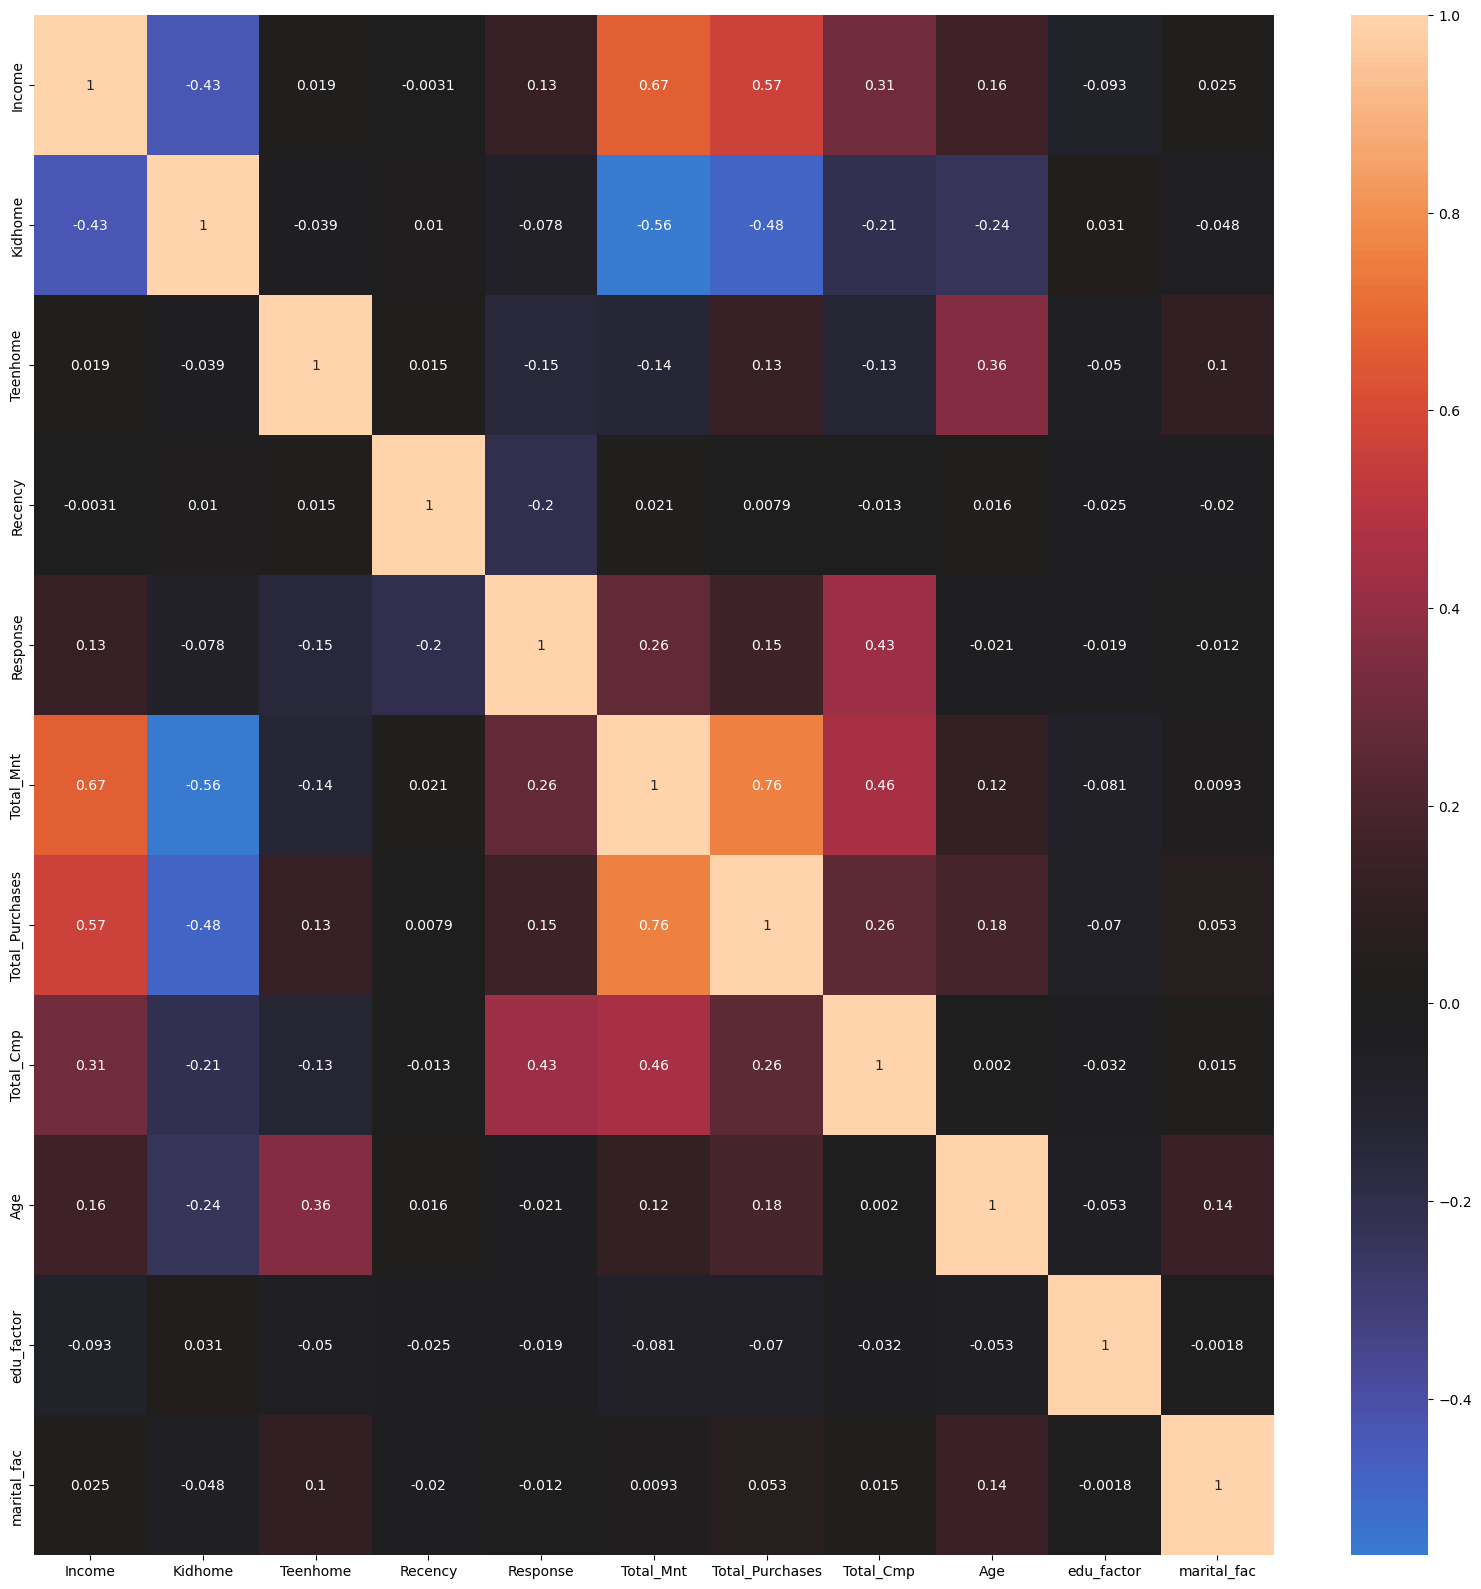

In [200]:
#correlation matrix
corrmat= df_new.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)



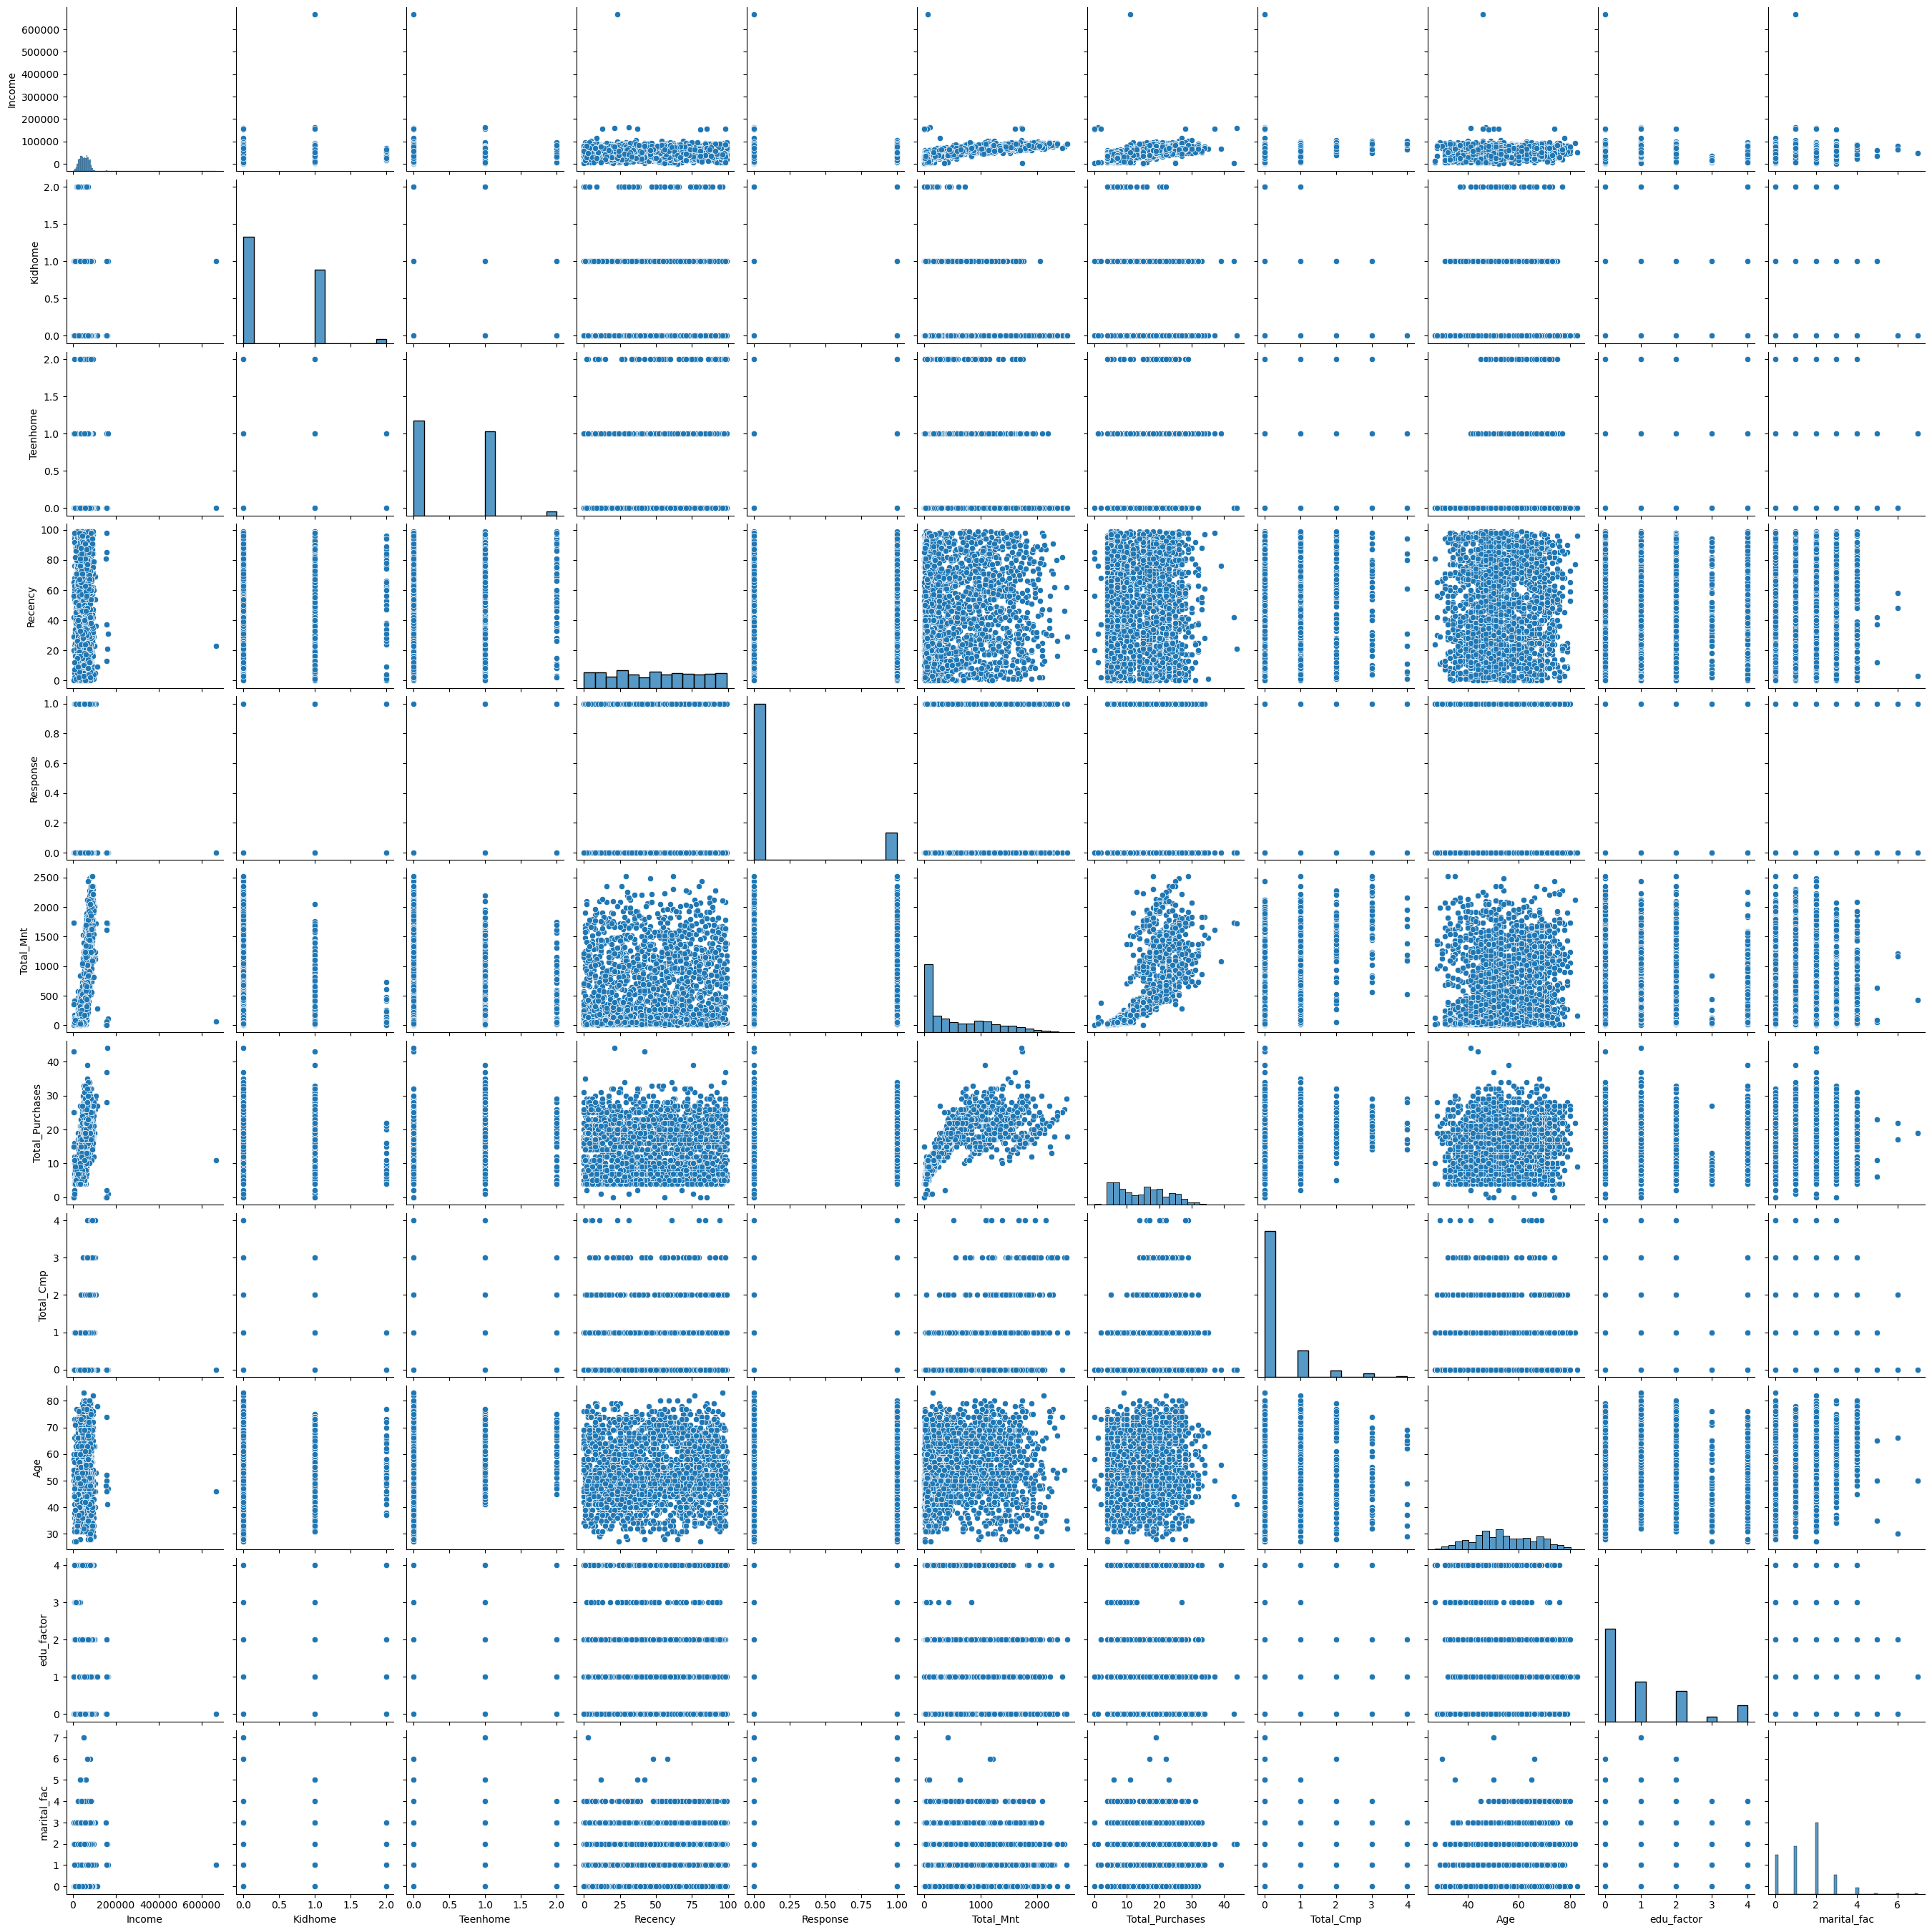

In [147]:
sns.pairplot(df_new)

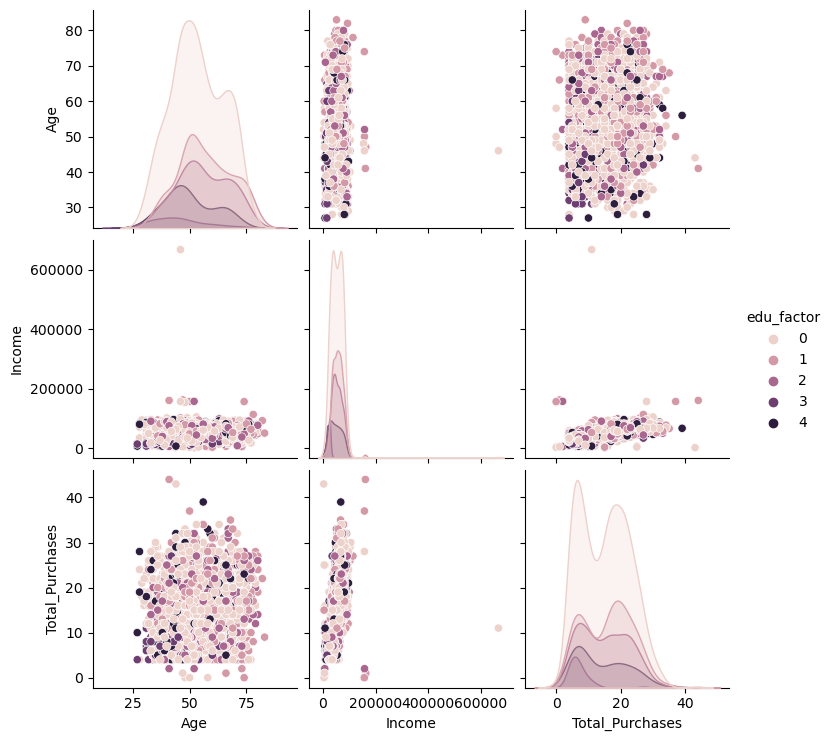

In [148]:
sns.pairplot(df_new, vars= ['Age', 'Income', 'Total_Purchases'], hue = 'edu_factor')

## Tuning

Besides the data, the only thing that we have in control is the number of the total cluster. The plot below will help us to deteremine the optimal number of cluster based on how big clusters are. As one can see, the number of cluster should be between 3 to 5. Additional cluster doesn't seemed to add more information to the dataset.

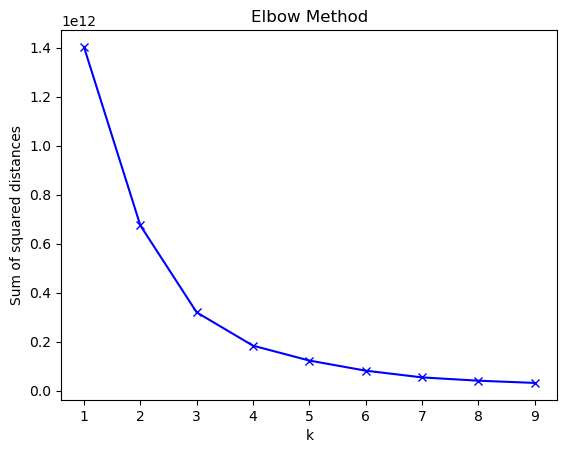

In [226]:
# Define the range of k values to test
k_values = range(1, 10)
# Calculate sum of squared distances for each k value
sum_squared_distances = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_new)
    sum_squared_distances.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(k_values, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

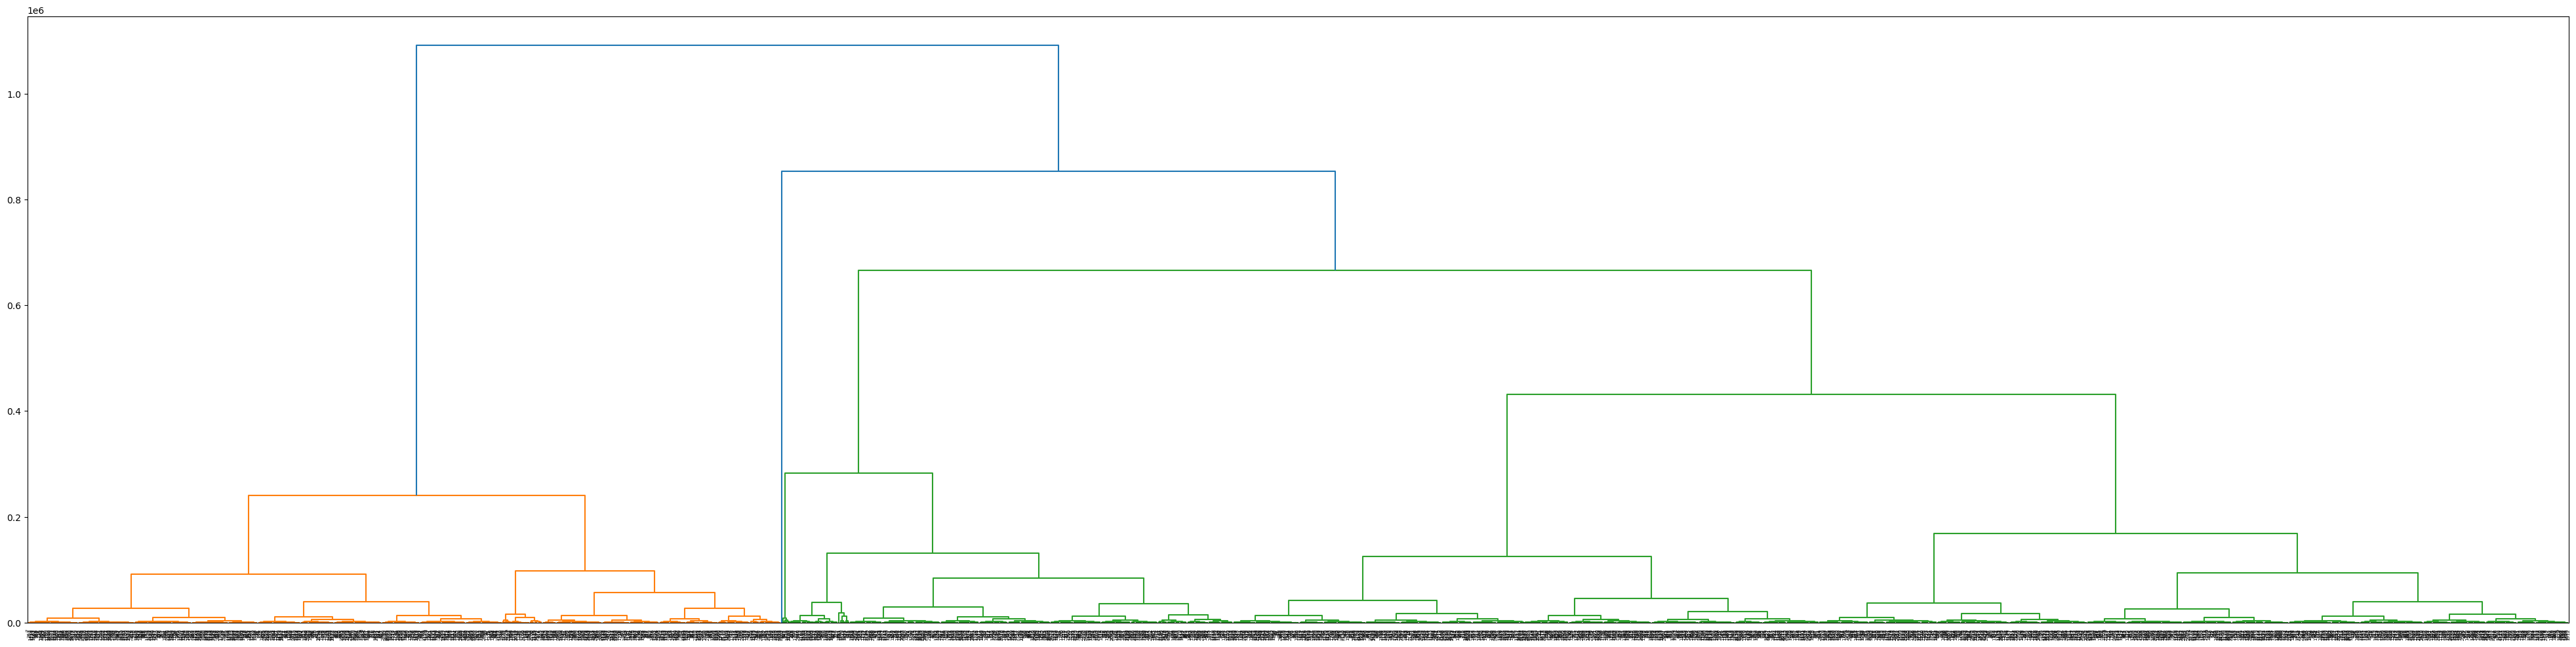

In [123]:
plt.figure(figsize=(50, 12))
dend=hcluster.dendrogram(hcluster.linkage(df_new,method='ward',metric='euclidean'))

## 2D Clustering - Age Vs Total_Purchases

It would be really hard to visualize anything beyond 3D, so we will start with a simple 2D for demonstration purpose

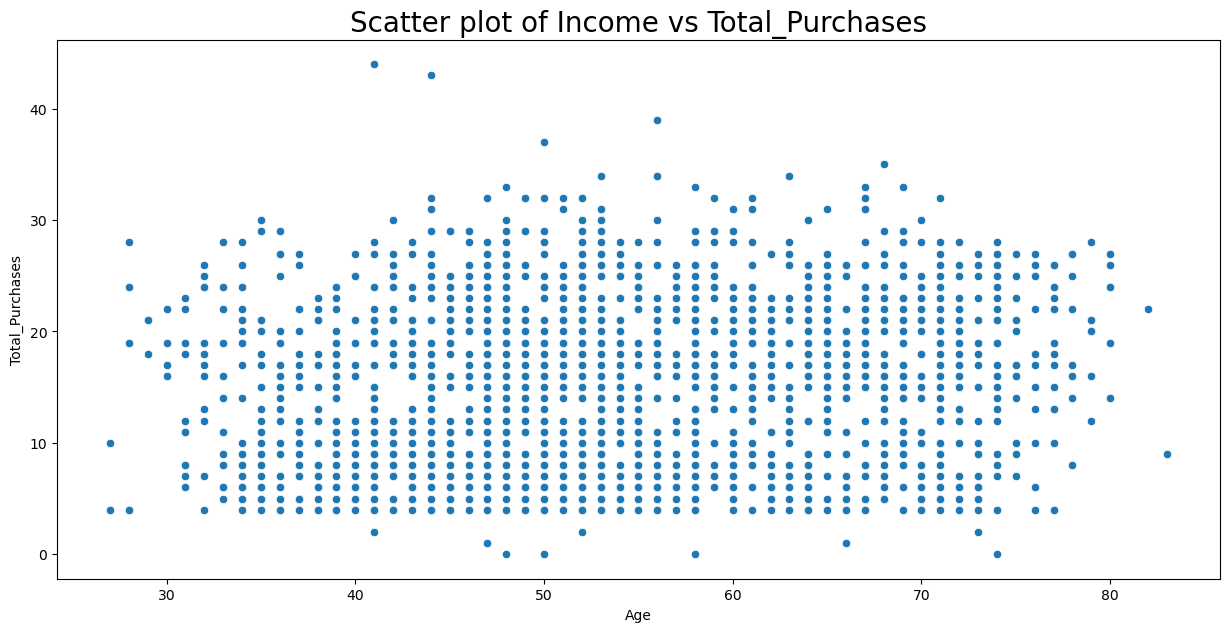

In [278]:

plt.figure(1 , figsize = (15 , 7))
plt.title('Scatter plot of Income vs Total_Purchases', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Total_Purchases')
sns.scatterplot( x = 'Age', y = 'Total_Purchases', data = df_new)
plt.show()



## Figure out number of clusters

We will use a similar tuning algorithem to figure out the optimal clusters for our 2d plot

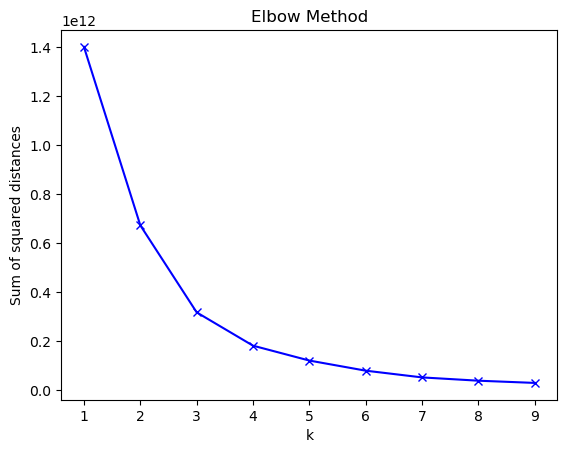

In [227]:
# Define the range of k values to test
k_values = range(1, 10)
df_2D = df_new[['Income', 'Total_Purchases']]
# Calculate sum of squared distances for each k value
sum_squared_distances = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_2D)
    sum_squared_distances.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(k_values, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

It seems 3 or 4 cluster would be the best. 4 might be over fitting a little, so I choose 3 for the 2D demonstration

<AxesSubplot:xlabel='Age', ylabel='Total_Purchases'>

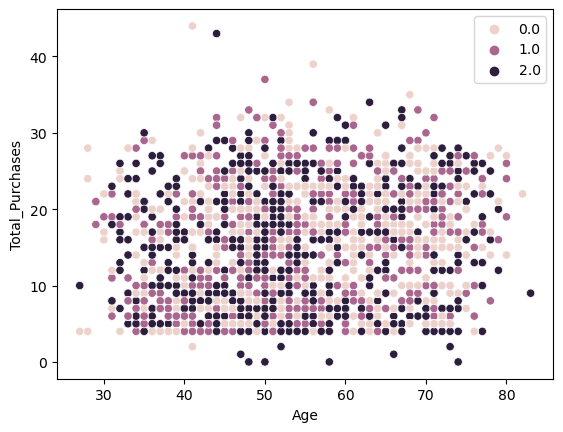

In [242]:
cluster1 = KMeans(n_clusters = 3)
cluster1.fit(df_new[['Age','Total_Purchases']])
labels1 = cluster1.labels_
centroids1 = cluster1.cluster_centers_


sns.scatterplot(x = 'Age', y = 'Total_Purchases', data = df_new, hue = pd.Series(labels1))



This doesn't look to good, I think it has to do with the nature of the data. Maybe its there is too few dimension for us to view the cluster. Maybe if we employe PCA to reduce the dimension and transform the axis further we might get a better idea of what is going on.

In [243]:
pca = PCA(n_components=2)
df_test = df_new[['Age','Total_Purchases']]
# fit and transform the data
pca = pca.fit_transform(df_test)

# create a new DataFrame with the reduced dimensions
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2'])
pca_df.head(5)

,PC1,PC2
0,13.671957,7.570806
1,12.879140,-11.648232
2,5.041825,5.221163
3,-16.142636,-3.790974
4,-11.039185,6.404848


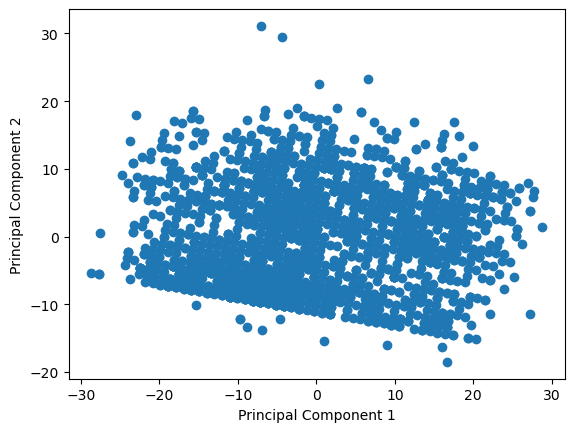

In [244]:
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

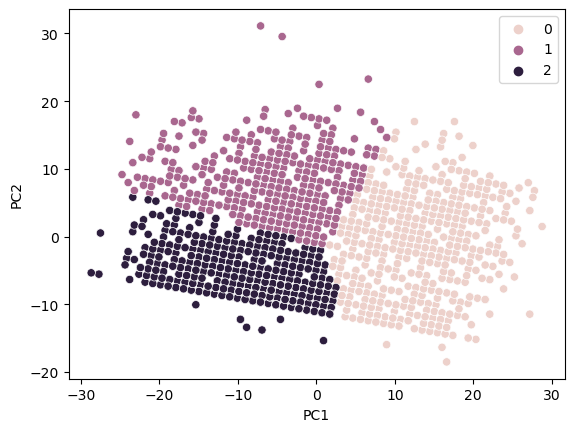

In [245]:
cluster1.fit(pca_df)
labels1 = cluster1.labels_
centroids1 = cluster1.cluster_centers_


sns.scatterplot(x = 'PC1', y = 'PC2', data = pca_df, hue = pd.Series(labels1))

This look much better! It really just mean that the cluster was there, but we can't visually see it because cluster were collapsed into a lower dimenstion

# The actual customer segmentations

I choose 5 for the number of clusters based on the first tuning algorithem. There were minimum decrease in cluster size after this number

In [269]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_new)
labels = kmeans.labels_
df_new['cluster'] = labels

Segment the customer into 5 groups

In [274]:
segments = df_new.groupby(labels)
means = segments.mean()
counts = segments.size().rename('count')  # rename the column to 'count'

# Combine the mean and count dataframes
result = pd.concat([means, counts], axis=1)

# Print the result
print(result)

          Income   Kidhome  Teenhome    Recency  Response    Total_Mnt  \
0   42191.008876  0.671598  0.656805  49.454142  0.119822   224.294379   
1   82717.037037  0.071605  0.239506  49.780247  0.316049  1420.051852   
2  666666.000000  1.000000  0.000000  23.000000  0.000000    62.000000   
3   62825.140089  0.201192  0.719821  48.636364  0.113264   866.666170   
4   23381.952174  0.780435  0.206522  48.269565  0.104348    76.086957   

   Total_Purchases  Total_Cmp        Age  edu_factor  marital_fac  cluster  \
0        11.238166   0.136095  54.402367    0.949704     1.505917      0.0   
1        20.829630   0.896296  55.116049    0.893827     1.464198      1.0   
2        11.000000   0.000000  46.000000    0.000000     1.000000      2.0   
3        20.134128   0.248882  56.949329    0.868852     1.600596      3.0   
4         7.384783   0.082609  48.539130    1.254348     1.386957      4.0   

   count  
0    676  
1    405  
2      1  
3    671  
4    460  


Here are the means for the 5 different customser segment. You may noticed that segment 2 only have 1 count, meaning only 1 dataset in that cluster. I think it has to do with the person's income, he's making a lot more money than other people. I wasn't sure what to do with that data set in data cleaning. The cluster would make more sense if I had dropped the outlier. 